In [1]:
import numpy as np
import pandas as pd 

import numpy as np
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

from torch import nn
import torch.utils.data

In [3]:
tsla_df = pd.read_csv('TSLA.csv', index_col='Date', parse_dates=['Date'])
tsla_df = tsla_df[['Open', 'High', 'Low', 'Volume', 'Close']]
print(tsla_df.info())
print(tsla_df.describe())
tsla_df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2416 entries, 2010-06-29 to 2020-02-03
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2416 non-null   float64
 1   High    2416 non-null   float64
 2   Low     2416 non-null   float64
 3   Volume  2416 non-null   int64  
 4   Close   2416 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 113.2 KB
None
              Open         High          Low        Volume        Close
count  2416.000000  2416.000000  2416.000000  2.416000e+03  2416.000000
mean    186.271147   189.578224   182.916639  5.572722e+06   186.403651
std     118.740163   120.892329   116.857591  4.987809e+06   119.136020
min      16.139999    16.629999    14.980000  1.185000e+05    15.800000
25%      34.342498    34.897501    33.587501  1.899275e+06    34.400002
50%     213.035003   216.745002   208.870002  4.578400e+06   212.960007
75%     266.450012   270.927513   262.102501  7.361150e+

,Open,High,Low,Volume,Close
Date,,,,,
2010-06-29,19.000000,25.00,17.540001,18766300,23.889999
2010-06-30,25.790001,30.42,23.299999,17187100,23.830000
2010-07-01,25.000000,25.92,20.270000,8218800,21.959999
2010-07-02,23.000000,23.10,18.709999,5139800,19.200001
2010-07-06,20.000000,20.00,15.830000,6866900,16.110001


In [4]:
def load_data(df, seq_len, out_feature=5, train_ratio=0.8, is_test=False):
    scaler = StandardScaler()
    scaler.fit(df)

    train_norm = scaler.transform(df)
    data = []
    for index in range(len(train_norm) - seq_len):
        # create all possible sequences
        data.append(train_norm[index:index + seq_len])

    data = np.array(data)

    train_len = len(data) if is_test else int(train_ratio * len(data))

    # train_x are sequences of seq_len-1 days. Features of each day are OPEN, CLOSE, HIGH, LOW, VOLUME
    # train_y is CLOSE price of day seq_len
    # shape is (n_data, n_sequence, features)
    train_x = data[:train_len, :-1, :]
    train_y = data[:train_len, -1, -out_feature:]

    val_x = data[train_len:, :-1, :]
    val_y = data[train_len:, -1, -out_feature:]

    return train_x, train_y, val_x, val_y

In [5]:
seq_len = 100
batch_size = 128
n_epoch = 50
n_feature = 5
out_feature = 1

train_df = tsla_df.loc[:'2018']
test_df = tsla_df.loc['2019':]

train_x, train_y, val_x, val_y = load_data(train_df, seq_len, out_feature=out_feature)

In [6]:
train_x = torch.from_numpy(train_x).float().cuda()
train_y = torch.from_numpy(train_y).float().cuda()
val_x = torch.from_numpy(val_x).float().cuda()
val_y = torch.from_numpy(val_y).float().cuda()

train = torch.utils.data.TensorDataset(train_x, train_y)
val = torch.utils.data.TensorDataset(val_x, val_y)

train_loader = torch.utils.data.DataLoader(dataset=train,
                                               batch_size=batch_size,
                                               shuffle=True, drop_last=True)

val_loader = torch.utils.data.DataLoader(dataset=val,
                                             batch_size=1,
                                             shuffle=False)

In [7]:
class StockRNN(nn.Module):

    def __init__(self, n_feature=5, out_feature=5, n_hidden=256, n_layers=2, drop_prob=0.5):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_feature = n_feature

        self.lstm = nn.LSTM(self.n_feature, self.n_hidden, self.n_layers, dropout=self.drop_prob, batch_first=True)

        self.dropout = nn.Dropout(drop_prob)

        self.fc = nn.Linear(n_hidden, out_feature)

    def forward(self, x, hidden):
        # x.shape (batch, seq_len, n_features)
        l_out, l_hidden = self.lstm(x, hidden)

        # out.shape (batch, seq_len, n_hidden*direction)
        out = self.dropout(l_out)

        # out.shape (batch, out_feature)
        out = self.fc(out[:, -1, :])

        # return the final output and the hidden state
        return out, l_hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data

        hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        return hidden

In [8]:
net = StockRNN(n_feature=n_feature, out_feature=out_feature)
net.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters())
val_loss_list = []

End of Epoch  0 Val loss:  0.2092770480879649
End of Epoch  1 Val loss:  0.20708479893272916
End of Epoch  2 Val loss:  0.028102624847492815
End of Epoch  3 Val loss:  0.08556903236229206
End of Epoch  4 Val loss:  0.03561101234238352
End of Epoch  5 Val loss:  0.04227914150878927
End of Epoch  6 Val loss:  0.03535580058668527
End of Epoch  7 Val loss:  0.03920554013169788
End of Epoch  8 Val loss:  0.028927796785426795
End of Epoch  9 Val loss:  0.02658176148724394
End of Epoch  10 Val loss:  0.023834895080090276
End of Epoch  11 Val loss:  0.024926456194973506
End of Epoch  12 Val loss:  0.025978517270553062
End of Epoch  13 Val loss:  0.029516607250096333
End of Epoch  14 Val loss:  0.031167424970860953
End of Epoch  15 Val loss:  0.02111486622089592
End of Epoch  16 Val loss:  0.022529135988334507
End of Epoch  17 Val loss:  0.02573730830150702
End of Epoch  18 Val loss:  0.02711301072818788
End of Epoch  19 Val loss:  0.022850635665102516
End of Epoch  20 Val loss:  0.020013987344

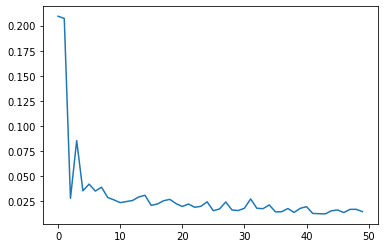

In [9]:
for epoch in range(n_epoch):

    for i, (x, y) in enumerate(train_loader):
        output, hidden = net(x, net.init_hidden(batch_size))
        loss = criterion(output, y)

        net.zero_grad()
        loss.backward()
        optimizer.step()

    net.eval()
    val_loss_sum = 0
    for i, (x, y) in enumerate(val_loader):
        with torch.no_grad():
            output, hidden = net(x, net.init_hidden(1))
            val_loss = criterion(output, y)
            val_loss_sum += val_loss.item()

    val_loss_list.append(val_loss_sum/len(val_loader))
    print('End of Epoch ', epoch, 'Val loss: ', val_loss_sum/len(val_loader))
    net.train()

plt.plot(val_loss_list)

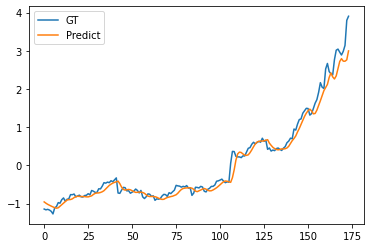

In [10]:
# test_df.shape
test_x, test_y, _, _ = load_data(test_df, seq_len, out_feature=out_feature, is_test=True)

test_x = torch.from_numpy(test_x).float().cuda()
test_y = torch.from_numpy(test_y).float().cuda()

test = torch.utils.data.TensorDataset(test_x, test_y)

test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=1, shuffle=False)

net.eval()
test_predict = []
for i, (x, y) in enumerate(test_loader):
    with torch.no_grad():
        output, hidden = net(x, net.init_hidden(1))
    test_predict.append(output[:, -1])

plt.plot(test_y[:, -1].cpu().numpy(), label='GT')
plt.plot(test_predict, label='Predict')
plt.legend()